# Bussiness Problem

The company Insurance all performed 127.000 with 380.000 customers about their interest in a new auto-insurance product. Their customer will demonstrate or not their interest in purchase the insurance.

    
As a result of our work we will produce a report with our analysis and the answers to the questions below:

   - Principal insights about more relevant attributes to custormers purchase an auto-insurance.
    
   - If the capacity of sales team increases to 40.000 calls, what would be the percetange of the customers interest in acquire an auto-insurance?
  
   - How many calls the sales team need to contact 80% of the customers interested in purchase an auto-insurance?


## Sprints - Schedule

**SPRINT 1 (05/01 - 12/01)**
 
Solution Planning (Done);

Data Collection (Done);

**SPRINT 2 (12/01 - 19/01)**

Descriptive Analysis;

Business Research (What is a cross-sell);

**SPRINT 3 (19/01 - 26/01)**

EDA;

Insight Report;

**SPRINT 4 (26/01 - 02/02)**

Data Preparation;

**SPRINT 5 (02/02 - 09/02)**

Implementation of Machine Learning Models;

**SPRINT 6 (09/02 - 16/02)**

Business Metrics (KPI);

Translate to business metrics;

**SPRINT 7 (16/02 - 23/02)**

Deploy of the Model in Production;

**SPRINT 8 (23/02 - 02/03)**

Access of the data in the Model in Production;

**SPRINT 9 (02/03 - 09/03)**

Presentation to Business Team;

**SPRINT 10 (09/03 - 16/03)**

Write an article;
What I Learned;

## Solution Plan

**1. Collect Data.**

   -  **Tools:**
   
       SQL(query to retrive data)
       Python(psycopg2, to connect with database)
       
   -  **Evidence of Completeness:**
   
       Dataframe in memory with all tables of databaseds.
       A .csv file in disk as backup of the data.

**2. Descriptive Analysis.**
    
   -  **Tools:**
   
      Python (pandas)
      
   -  **Evidence of Completeness:**
   
      Jupyter notebook with:
      
        Target Balance.
        Descriptive stats for numerical variables(mean, median, mim, max).
        Frequency plots for categorical variables.
        If there is missing values.
        Presence of outliers.
        
**3. EDA / Insight Report.**
    
   - **Tools:**
    
       Draw.io(For mapmind of hypotesis)
       Python(pandas, matplotlib, seaborn)
       Jupyter notebooks
       
   - **Evidence of Completeness:**
    
       Jupyter notebook with insights between interest and not interest and behavior in data

**4. Data Preparation**
    
   - **Tools:**
    
       Python for transformations and Feature Engineering
       Jupyter notebook for documetation
    
   - **Evidence of completeness:**
    
       Jupyter notebook with the implemetantion of all transformations and Feature Engineering

**5. Machine Learning Models**

   - **Tools:**
    
       Python as the programing language
       Pycaret(AutoMl) for auto test several models
       Keras for develop my first NN
       Jupyter notebook for documetation
      
   - **Evidence of completeness:**
    
       Jupyter notebook with the implemetantions

**6. Business Metrics**
   
   - **Tools:**
   
      Python as a programing language
      Jupyter notebooks for documentation
   
   - **Evidence of completeness:**
   
     Jupyter notebooks
       % interested customers will be contacted with 20.000 calls;
       % interested customers will be contacted with 40.000 calls;
   

**7. Deploy the Model**

**8. Presentation**

**9. Article**

## Imports

In [2]:
import os
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import postgres_crud as pc
import matplotlib.pyplot as plt

## Helper Functions

# Coletando os Dados

## Conhecendo as tabelas do BD.

In [5]:
# Parametros
HOST =     ##### 
PORT =     ##### 
DATABASE = ##### 
USERNAME = ##### 
PASSWORD = ##### 

# Query SQL to find the tables names
query =   """
          SELECT table_name 
          FROM information_schema.tables
          WHERE table_schema='pa004'
          AND table_type='BASE TABLE';
          
          """

data = pc.Postgresql.retrieve_data(query=query,
                                   user=USERNAME,
                                   password=PASSWORD,
                                   host=HOST,
                                   port=PORT,
                                   database=DATABASE,
                                   connect=True,
                                   objeto = 'pd')

data

Buscando os dados!!!
Conexão com Postgresql fechada


,table_name
0,users
1,vehicle
2,insurance


Cool we have three tables to work with 'users', 'vehicle', 'insurance'. Let's get them individually.

In [6]:
# querys
query_insurance = """SELECT * FROM pa004.insurance; """
query_users = """SELECT * FROM pa004.users; """
query_vehicle = """SELECT * FROM pa004.vehicle; """

QUERY_LIST = [query_insurance,query_users, query_vehicle]

# Generating a list of dataframes
dataframes = []
for query in QUERY_LIST:
    
    data = pc.Postgresql.retrieve_data(query=query,
                                   user=USERNAME,
                                   password=PASSWORD,
                                   host=HOST,
                                   port=PORT,
                                   database=DATABASE,
                                   connect=True,
                                   objeto = 'pd')
    dataframes.append(data)
    

# Checking duplicated ids
print("\nThere is duplicated ids ?")
for i in range(0,3):
    df = dataframes[i]
    dp = df[['id']].duplicated()
    result = dp.unique()
    print(f'\nDuplicated ids in df {i} - {result}')

Buscando os dados!!!
Conexão com Postgresql fechada
Buscando os dados!!!
Conexão com Postgresql fechada
Buscando os dados!!!
Conexão com Postgresql fechada

There is duplicated ids ?

Duplicated ids in df 0 - [False]

Duplicated ids in df 1 - [False]

Duplicated ids in df 2 - [False]


In [7]:
# Splitting the dataframes in differents DFs.

# Insurance df
insurance_df = dataframes[0]
# Users df
users_df = dataframes[1]
# Vehicle df
vehicles_df = dataframes[2]

# Logical Test - we want a empty set
diff = set(insurance_df['id']).difference(set(users_df['id']), set(vehicles_df['id']))
print(diff)

set()


In [8]:
dataframes[2].head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


## Retriving all data with one Query

In [9]:
# Query SQL to find the tables names
query =   """
            SELECT * 
            FROM pa004.insurance i
            INNER JOIN pa004.users u
                 on i.id = u.id 
            INNER JOIN pa004.vehicle v
                 on u.id = v.id
          """

data = pc.Postgresql.retrieve_data(query=query,
                                   user=USERNAME,
                                   password=PASSWORD,
                                   host=HOST,
                                   port=PORT,
                                   database=DATABASE,
                                   connect=True,
                                   objeto = 'pd')

data.head()

Buscando os dados!!!
Conexão com Postgresql fechada


,id,previously_insured,annual_premium,vintage,response,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes
1,13,1,31409.0,221,0,13,Female,41,15.0,14.0,13,1,1-2 Year,No
2,18,1,46622.0,299,0,18,Female,25,35.0,152.0,18,1,< 1 Year,No
3,31,0,2630.0,136,0,31,Female,26,8.0,160.0,31,1,< 1 Year,No
4,39,0,42297.0,264,0,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes


In [10]:
# Saving the data in disk, this way we dont need to send unnecessary requests to our database.
data.to_csv('data/full_database.csv')

# Data Description

In [3]:
# Collecting the data from disk.
data = pd.read_csv('data/full_database.csv')

# Dropping redudant columns.
data.drop(['Unnamed: 0','id.1','id.2'], inplace=True, axis=1)

In [4]:
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes


## General Describe of Data. 

In [20]:
# Describe
pd.DataFrame({'missing' :data.isna().mean(),
              'uniques' :data.nunique(),
              'dtypes'  :data.dtypes,
              'min'     :data.min(),
              'mean'    :data.mean(),
              'median'  :data.median(),
              'max'     :data.max(),
              'skew'    :data.skew(),
              'kurtosis':data.kurtosis()})

,missing,uniques,dtypes,min,mean,median,max,skew,kurtosis
age,0.0,66,int64,20,38.822584,36.0,85,6.725390e-01,-0.565655
annual_premium,0.0,48838,float64,2630.0,30564.389581,31669.0,540165.0,1.766087e+00,34.004569
driving_license,0.0,2,int64,0,0.997869,1.0,1,-2.159518e+01,464.354302
gender,0.0,2,object,Female,NaN,NaN,Male,NaN,NaN
id,0.0,381109,int64,1,190555.000000,190555.0,381109,-8.071174e-18,-1.200000
policy_sales_channel,0.0,155,float64,1.0,112.034295,133.0,163.0,-9.000081e-01,-0.970810
previously_insured,0.0,2,int64,0,0.458210,0.0,1,1.677471e-01,-1.971871
region_code,0.0,53,float64,0.0,26.388807,28.0,52.0,-1.152664e-01,-0.867857
response,0.0,2,int64,0,0.122563,0.0,1,2.301906e+00,3.298788
vehicle_age,0.0,3,object,1-2 Year,NaN,NaN,> 2 Years,NaN,NaN


 - We have no missing value.
 - annual_premium, policy_sales_channel, region_code, vintage has diferent scales min: 2630.0  max: 540165.0.
 - driving_license, previously_insured, vehicle_age, vehicle_damage, previously_insured is categorical feature and    not int64. 
 - response is our Target variable.
 - id is our unique feature.

## Changing dtypes of our dataset

In [54]:
# Category variabels
variables = ['driving_license', 
             'previously_insured', 
             'vehicle_age', 
             'vehicle_damage', 
             'previously_insured', 
             'gender',
             'response']

for var in variables:
    data[var] = data[var].astype('category')

## Target - response

response
0    87.743664
1    12.256336
Name: id, dtype: float64

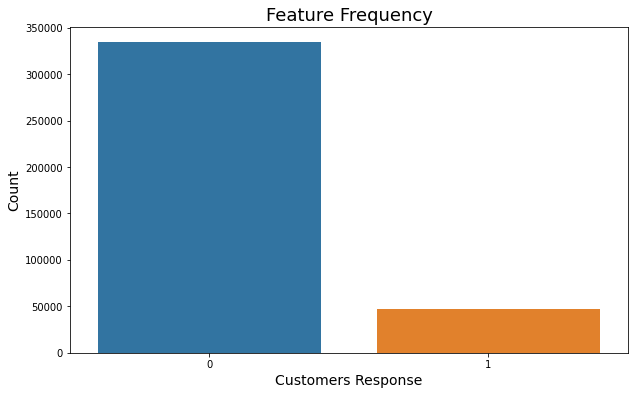

In [59]:
# Checkando o balanciamento da variável Target
ax = sns.countplot(x='response', hue=None, data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Customers Response', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

# Percentual de observações por valores Geography
data.groupby('response').count()['id'].apply(lambda x: (x/data.shape[0])*100)

- We have an unbalanced target with 87.74% to not interested and 12.25% to interest in purchase the insurance.

## Gender vs Response

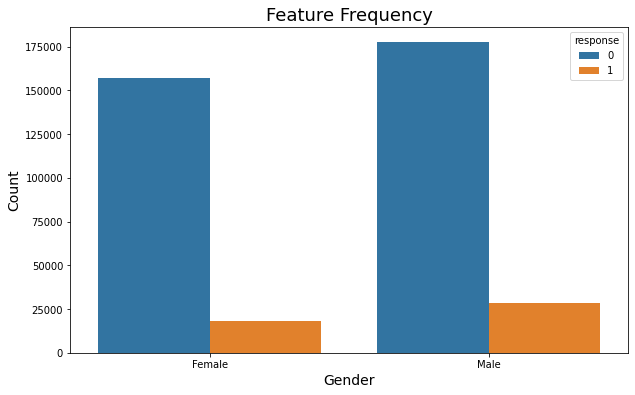

In [60]:
ax = sns.countplot(x='gender', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [66]:
# Porcentage of observations by Gender
data.groupby('gender').count()['id'].apply(lambda x: (x/data.shape[0])*100)

gender
Female    45.92387
Male      54.07613
Name: id, dtype: float64

- We cant find a concentration of the positive event by gender. With the majority of males

## driving_license vs response

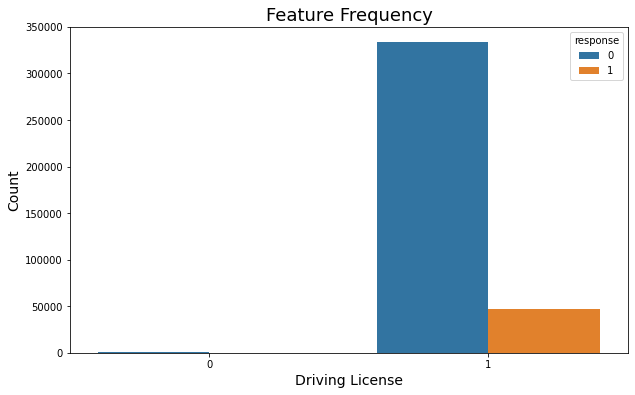

In [61]:
ax = sns.countplot(x='driving_license', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Driving License', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [67]:
# Porcentage of observations by driving_license
data.groupby('driving_license').count()['id'].apply(lambda x: (x/data.shape[0])*100)

driving_license
0     0.213062
1    99.786938
Name: id, dtype: float64

- We can see that the majority of our customers has driving license.

## previously_insured vs response

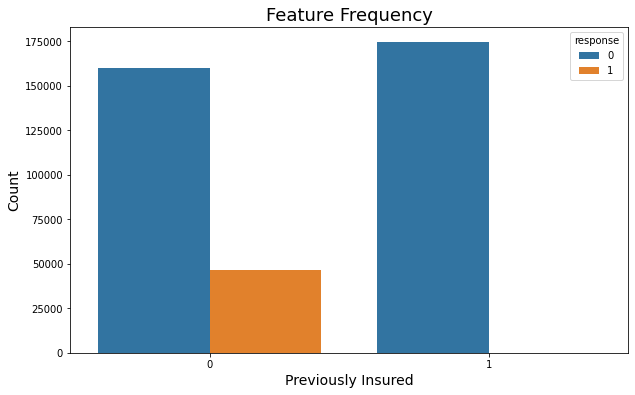

In [62]:
ax = sns.countplot(x='previously_insured', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Previously Insured', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [68]:
# Porcentage of observations by previously_insured
data.groupby('previously_insured').count()['id'].apply(lambda x: (x/data.shape[0])*100)

previously_insured
0    54.178988
1    45.821012
Name: id, dtype: float64

- We can see that the interest in purchase a insurance is higher when you dont have a previously insured.

## vehicle_age vs response

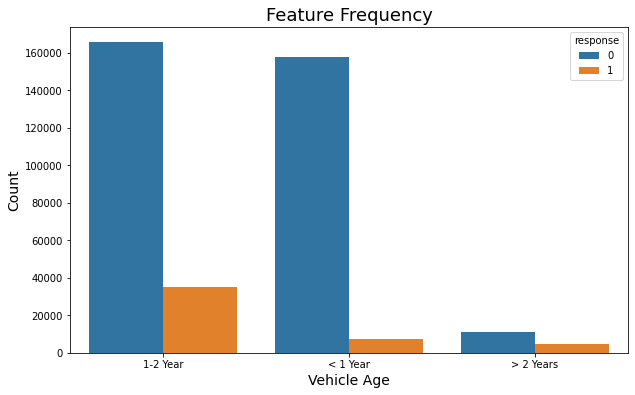

In [63]:
ax = sns.countplot(x='vehicle_age', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Vehicle Age', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Strong concentration of interest with owner between 1 and 2 years also its the majority in the 1-2 Year category.

In [69]:
# Porcentage of observations by previously_insured
data.groupby('vehicle_age').count()['id'].apply(lambda x: (x/data.shape[0])*100)

vehicle_age
1-2 Year     52.561341
< 1 Year     43.238549
> 2 Years     4.200111
Name: id, dtype: float64

## vehicle_damage vs response

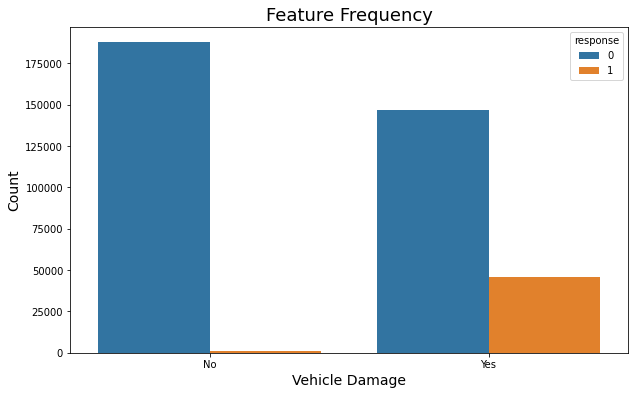

In [64]:
ax = sns.countplot(x='vehicle_damage', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Vehicle Damage', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Strong concentration of interest with owners of damaged vehicle.

In [70]:
# Porcentage of observations by previously_insured
data.groupby('vehicle_damage').count()['id'].apply(lambda x: (x/data.shape[0])*100)

vehicle_damage
No     49.512344
Yes    50.487656
Name: id, dtype: float64

## Cheking the presense of outliers

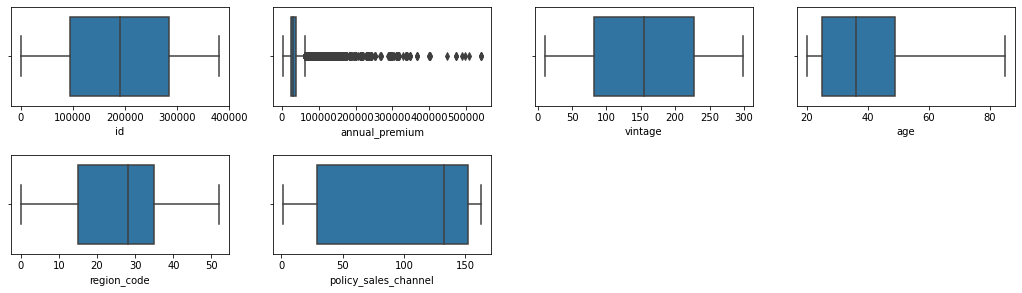

In [55]:
# Variáveis
variables = data.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in data[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=data)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

- We can observe outliers at annual_premimum.

### annual_premium

In [58]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(data['annual_premium'], .25)
Q3 = np.quantile(data['annual_premium'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'Low Limit is {low}')
print(f'High Limit is {high}')

Low Limit is 1912.5
High Limit is 61892.5


# Data Cleaning